## Fitting data using scipy.optimize.curve_fit
Documentation for curve_fit can be found at
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit

Other minimization routines are available and may be more suitable depending on the circumstances of the problem. scipy.optimize.least_squares is more general and may be useful for shared parameter fitting. lmfit has more "features" and may be more user friendly in that way. pymc3 would be useful for Bayesian inference.

In [27]:
# Import statements
import math as m  # this module has standard calculator math functions
import numpy as np  # this module has array handling and math functions
import matplotlib.pyplot as plt # this module makes graphs with a matlab style syntax
from scipy.optimize import curve_fit # this function solves curve fitting least-squares problems. Several methods are available. LM is recommended for unconstrained problems.

In [28]:
# Synthesize data. For real data one could load data from a text file, excel, or database
t = np.linspace(0, 10, 20)
C = 15*np.exp(-0.25*t) + np.random.normal(0,0.5, size = len(t))

The output of curve_fit includes two arrays
(array([15.23647244,  0.2497327 ]), array([[9.88567908e-02, 1.75248907e-03],
       [1.75248907e-03, 6.78424096e-05]]))

Fitted values +/- standard deviations
C0 = 15.2365 +/- 0.314415
k = 0.249733 +/- 0.00823665


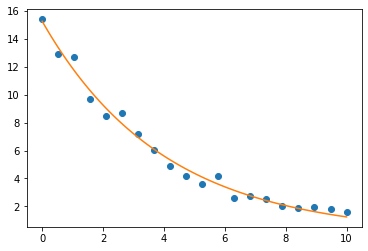

In [29]:
# Create a fitting function in the format f(xdata, params)
def ExpDecay(t, C0, k):
    # compute and return the modeled y values
    return C0*np.exp(-k*t)

# Execute curve_fit
result = curve_fit(ExpDecay, t, C, p0=[10, 0.2])
print("The output of curve_fit includes two arrays")
print(result)

# unpack result into optimized parameters and covariance
popt, pcov = result

# print the results in a more standard format
print('')
print('Fitted values +/- standard deviations')
print('C0 = %g +/- %g' % (popt[0], m.sqrt(pcov[0,0])))
print('k = %g +/- %g' % (popt[1], m.sqrt(pcov[1,1])))

# plotting the fitted curve
plt.plot(t, C, 'o')
plt.plot(np.linspace(t[0],t[-1], 100), ExpDecay(np.linspace(t[0],t[-1], 100), popt[0], popt[1]))

## Running a PHREEQC calculation in python
The following requires installation of the IPhreeqc COM. This is avaialble at https://www.usgs.gov/software/phreeqc-version-3

It may be more computationally efficient to use cython to create a python module based on the C source code available in PhreeqcRM but that would take some wrangling. I understand that GoldSim is doing something along these lines for their monte carlo software.

This module may also be worth exploring: https://www.phreeqpy.com/

In [42]:
# Import module to load in the COM.
from win32com.client import Dispatch

# Create function to run a Phreeqc input file contained in input_string using the thermodynamic database in db_path
def selected_array(db_path, input_string):
    """Load database via COM and run input string.
    """
    dbase = Dispatch('IPhreeqcCOM.Object')
    dbase.LoadDatabase(db_path)
    dbase.RunString(input_string)
    return dbase.GetSelectedOutputArray()

# Run a Phreeqc input file -- use Example 8 in the Phreeqc documentation since that seems similar to the phosphate sorption case
# Create input string
Example8 = """
    SURFACE_SPECIES
        Hfo_sOH + H+ = Hfo_sOH2+
        log_k 7.18
        Hfo_sOH = Hfo_sO- + H+
        log_k -8.82
        Hfo_sOH + Zn+2 = Hfo_sOZn+ + H+
        log_k 0.66
        Hfo_wOH + H+ = Hfo_wOH2+
        log_k 7.18
        Hfo_wOH = Hfo_wO- + H+
        log_k -8.82
        Hfo_wOH + Zn+2 = Hfo_wOZn+ + H+
        log_k -2.32
    SURFACE 1
        Hfo_sOH 5e-6 600. 0.09
        Hfo_wOH 2e-4
        # -donnan
    SOLUTION 1
        -units mmol/kgw
        pH 8.0
        Zn 0.0001
        Na 100. charge
        N(5) 100.
    END
    USE solution 1
    USE surface 1
    PHASES
        Fix_H+
        H+ = H+
        log_k 0.0
    EQUILIBRIUM_PHASES 1
        Fix_H+ -5 NaOH 10.0
    SELECTED_OUTPUT
        -reset false
        -solution true
        -simulation           true
        -ph                   true
        -Totals       Zn
    END
"""
# Specify database
db = r"C:\phreeqc\database\PHREEQC.dat"
# Run the Example8 string
result = selected_array(db, Example8)
print(result)

# unpacking the pH and Zn values
print('')
print('at pH = %g, dissolved Zn = %g mol/kgw' % (result[1][2], result[1][3]))

(('sim', 'soln', 'pH', 'Zn(mol/kgw)'), (2, 1, 5.0, 9.967255206724086e-08))

at pH = 5, dissolved Zn = 9.96726e-08 mol/kgw


## Creating a function that could be used in curve_fit
Assuming that the surface concentration of strong and weak binding sites are the parameters and that the data are dissolved Zn as a function of pH

In [49]:
def Sorption(pH_arr, Hfo_sOH, Hfo_wOH):
    # Set the total Zn value
    Zn_tot = 0.0001
    # Create array for output dissolved Zn values
    Zn_arr = np.zeros_like(pH_arr)
    # Loop over the pH values
    for index, pH in enumerate(pH_arr):
        # Create the Phreeqc input string, insert variable values using printf syntax
        Example8 = """
        SURFACE_SPECIES
            Hfo_sOH + H+ = Hfo_sOH2+
            log_k 7.18
            Hfo_sOH = Hfo_sO- + H+
            log_k -8.82
            Hfo_sOH + Zn+2 = Hfo_sOZn+ + H+
            log_k 0.66
            Hfo_wOH + H+ = Hfo_wOH2+
            log_k 7.18
            Hfo_wOH = Hfo_wO- + H+
            log_k -8.82
            Hfo_wOH + Zn+2 = Hfo_wOZn+ + H+
            log_k -2.32
        SURFACE 1
            Hfo_sOH %g 600. 0.09
            Hfo_wOH %g
            # -donnan
        SOLUTION 1
            -units mmol/kgw
            pH 8.0
            Zn %g
            Na 100. charge
            N(5) 100.
        END
        USE solution 1
        USE surface 1
        PHASES
            Fix_H+
            H+ = H+
            log_k 0.0
        EQUILIBRIUM_PHASES 1
            Fix_H+ -%g NaOH 10.0
        SELECTED_OUTPUT
            -reset false
            -solution true
            -simulation           true
            -ph                   true
            -Totals       Zn
        END
        """ % (Hfo_sOH, Hfo_wOH, Zn_tot, pH)
        # Specify database
        db = r"C:\phreeqc\database\PHREEQC.dat"
        # Run the Example8 string
        result = selected_array(db, Example8)
        # Populate Zn_arr with result
        Zn_arr[index] = result[1][3]
    # return
    return Zn_arr


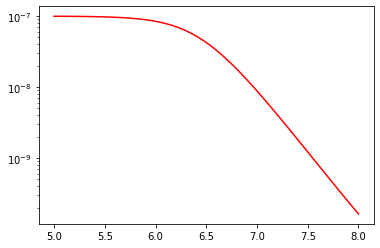

In [65]:
# Use the function to make a graph of dissolved Zn vs pH
pH = np.linspace(5,8,50)
Zn_dis = Sorption(pH, 5e-6, 2e-4)
plt.semilogy(pH, Zn_dis, 'r-')

The plot should compare to the red line in Fig 9 in the Phreeqc manual (copied below)
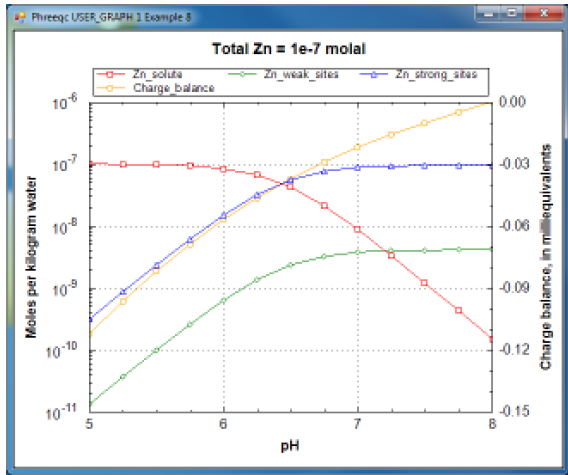

## Try out the curve fitting function
I'll make up some data by eyeballing values from the PHREEQC Fig 9 then try to fit.

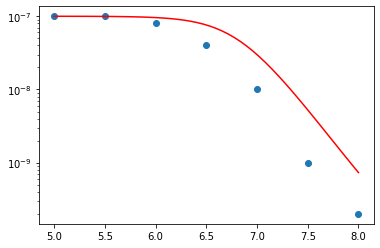

In [92]:
# Sythetic data
pH_data = np.array([5, 5.5, 6, 6.5, 7, 7.5, 8])
Zn_data = np.array([1e-7, 1e-7, 8e-8, 4e-8, 1e-8, 1e-9, 2e-10])
# Plot
plt.semilogy(pH_data, Zn_data, 'o')
pH = np.linspace(5,8,50)
Zn_dis = Sorption(pH, 1e-6, 2e-4)
plt.semilogy(pH, Zn_dis, 'r-')

In [93]:
# Applying curve_fit. (Note that I weighted the data which is generally necesary for data like these, though I would advocate for an iterative reweighting approach if these were real data)
# Also, I'm holding the Hfo_wOH parameter because of a lack of identifiability
f = lambda pH_arr, Hfo_sOH : Sorption(pH_arr, Hfo_sOH, 2e-4)
result = curve_fit(f, pH_data, Zn_data, p0=[1e-6], sigma=Zn_data, bounds=(0,np.inf) ,method='trf')
print(result)

(array([5.09852322e-06]), array([[1.54527521e-13]]))


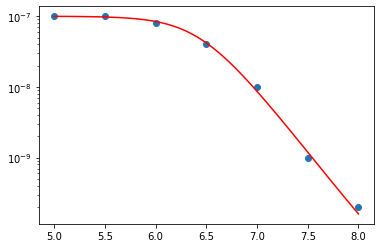

In [94]:
# Plot the fitting results
plt.semilogy(pH_data, Zn_data, 'o')
pH = np.linspace(5,8,50)
Zn_dis = Sorption(pH, result[0][0], 2e-4)
plt.semilogy(pH, Zn_dis, 'r-')